In [1]:
from __future__ import annotations
import os
import numpy as np
from pytomography.io.SPECT import dicom
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM, BSREM, KEM
import matplotlib.pyplot as plt
import pytomography
import torch
import matplotlib.patches as patches
from pytomography.priors import RelativeDifferencePrior
from pytomography.priors import TopNAnatomyNeighbourWeight
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.transforms.shared import KEMTransform
from pytomography.projectors.shared import KEMSystemMatrix
import matplotlib
import itk
import pydicom
import matplotlib.patheffects as pe
import time
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# DICOM

In [2]:
input_path = '/disk1/pytomography_paper_data/input'
output_path = '/disk1/pytomography_paper_data/output'

In [3]:
files_NM = [
    os.path.join(input_path, 'spect_dicom_experiment', 'dicom_multibed_tutorial', 'bed1_projections.dcm'),
    os.path.join(input_path, 'spect_dicom_experiment', 'dicom_multibed_tutorial', 'bed2_projections.dcm'),
]
path_CT = os.path.join(input_path, 'spect_dicom_experiment', 'dicom_multibed_tutorial', 'CT')
files_CT = [os.path.join(path_CT, file) for file in os.listdir(path_CT)]

projections1, projections2 = projectionss = dicom.load_multibed_projections(files_NM)
attenuation_map1 = dicom.get_attenuation_map_from_CT_slices(
        files_CT, files_NM[0], index_peak=1
    )
attenuation_map2 = dicom.get_attenuation_map_from_CT_slices(
        files_CT, files_NM[1], index_peak=1
    )

Given photopeak energy 208.0 keV and CT energy 120 keV from the CT DICOM header, the HU->mu conversion from the following configuration is used: 208.0 keV SPECT energy, 120 keV CT energy, and scanner model optimact540
Given photopeak energy 208.0 keV and CT energy 120 keV from the CT DICOM header, the HU->mu conversion from the following configuration is used: 208.0 keV SPECT energy, 120 keV CT energy, and scanner model optimact540


Open and stitch MIM recon

In [ ]:
object_meta, proj_meta = dicom.get_metadata(files_NM[0], index_peak=1)
factor = 1/np.prod(object_meta.dr) / 15 # s # counts/second/mL
# Rough calibration factor https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7013023/
CPS_to_kBq = 6.2e-3
factor /= CPS_to_kBq # to kBq/mL

Open and stitch two MIM bed positions

In [ ]:
ds_lower_path = os.path.join(input_path, 'spect_dicom_experiment', 'MIM_recon', 'recon_lower_bed.dcm') 
ds_upper_path = os.path.join(input_path, 'spect_dicom_experiment', 'MIM_recon', 'recon_upper_bed.dcm')
save_numpy_path = os.path.join(output_path, 'spect_dicom_experiment', 'dicomMIMOSEM4it6ss.npy')
save_nrrd_path = os.path.join(output_path, 'spect_dicom_experiment', 'dicomMIMOSEM4it6ss.nrrd')

ds_lower= pydicom.read_file(ds_lower_path)
recon_lower = np.transpose(ds_lower.pixel_array, (2,1,0)) * ds_lower.RealWorldValueMappingSequence[0].RealWorldValueSlope / 60
ds_upper = pydicom.read_file(ds_upper_path)
recon_upper = np.transpose(ds_upper.pixel_array, (2,1,0)) * ds_upper.RealWorldValueMappingSequence[0].RealWorldValueSlope / 60
recon_stitched_MIM = dicom.stitch_multibed(
    recons=torch.stack([torch.tensor(recon_upper), torch.tensor(recon_lower)]).to(pytomography.device),
    files_NM = files_NM) * factor

np.save(save_numpy_path, recon_stitched_MIM.cpu().numpy())
itk_image = itk.GetImageFromArray(np.transpose(recon_stitched_MIM.cpu().numpy(),(2,0,1)))
itk.imwrite(itk_image, save_nrrd_path)

In [ ]:
ENERGY = 208 
INDEX_PEAK = 1
INDEX_LOWER = 3
INDEX_UPPER = 2

def get_likelihood_singlebed(i):
    file_NM = files_NM[i]
    projections = projectionss[i]
    object_meta, proj_meta = dicom.get_metadata(file_NM, index_peak=INDEX_PEAK)
    photopeak = projections[INDEX_PEAK]
    scatter = dicom.get_energy_window_scatter_estimate_projections(file_NM, projections, index_peak=INDEX_PEAK, index_lower=INDEX_LOWER, index_upper=INDEX_UPPER)
    # Build system matrix
    attenuation_map = dicom.get_attenuation_map_from_CT_slices(
        files_CT, file_NM, index_peak=INDEX_PEAK
    )
    psf_meta = dicom.get_psfmeta_from_scanner_params('GI-MEGP', energy_keV=ENERGY)
    att_transform = SPECTAttenuationTransform(attenuation_map)
    psf_transform = SPECTPSFTransform(psf_meta)
    # Create system matrix
    system_matrix = SPECTSystemMatrix(
        obj2obj_transforms = [att_transform, psf_transform],
        proj2proj_transforms = [],
        object_meta = object_meta,
        proj_meta = proj_meta)
    return photopeak, scatter, system_matrix, PoissonLogLikelihood(system_matrix, photopeak, additive_term=scatter)

photopeak_upper, scatter_upper, system_matrix_upper, likelihood_upper = get_likelihood_singlebed(0)
photopeak_lower, scatter_lower, system_matrix_lower, likelihood_lower = get_likelihood_singlebed(1)

Given photopeak energy 208.0 keV and CT energy 120 keV from the CT DICOM header, the HU->mu conversion from the following configuration is used: 208.0 keV SPECT energy, 120 keV CT energy, and scanner model optimact540
Given photopeak energy 208.0 keV and CT energy 120 keV from the CT DICOM header, the HU->mu conversion from the following configuration is used: 208.0 keV SPECT energy, 120 keV CT energy, and scanner model optimact540


Reconstruct using OSEM and time

In [ ]:
start = time.time()
recon_upper = OSEM(likelihood_upper)(4,6)
end = time.time()
print(f'Time for recon of upper bed per iteration: {(end-start)/4}')
recon_lower = OSEM(likelihood_lower)(4,6)
recon_stitched = dicom.stitch_multibed(
    recons=torch.stack([recon_upper, recon_lower]),
    files_NM = files_NM) * factor

save_numpy_path = os.path.join(output_path, 'spect_dicom_experiment', 'dicomOSEM4it6ss.npy')
save_nrrd_path = os.path.join(output_path, 'spect_dicom_experiment', 'dicomOSEM4it6ss.nrrd')
np.save(save_numpy_path, recon_stitched.cpu().numpy())
itk_image = itk.GetImageFromArray(np.transpose(recon_stitched.cpu().numpy(),(2,0,1)))
itk.imwrite(itk_image, save_nrrd_path)

Time for recon of upper bed per iteration: 4.2232866287231445


In [ ]:
prior_rdp_upper = RelativeDifferencePrior(beta=0.3, gamma=2)
prior_rdp_lower = RelativeDifferencePrior(beta=0.3, gamma=2)
start = time.time()
recon_upper = BSREM(likelihood = likelihood_upper, prior = prior_rdp_upper)(40,6)
end = time.time()
print(f'Time for recon of upper bed per iteration: {(end-start)/40}')
recon_lower = BSREM(likelihood = likelihood_lower, prior = prior_rdp_lower)(40,6)
recon_stitched = dicom.stitch_multibed(
    recons=torch.stack([recon_upper, recon_lower]),
    files_NM = files_NM) * factor

save_numpy_path = os.path.join(output_path, 'spect_dicom_experiment', 'dicomBSREM-RDP40it6ss.npy')
save_nrrd_path = os.path.join(output_path, 'spect_dicom_experiment', 'dicomBSREM-RDP40it6ss.nrrd')
np.save(save_numpy_path, recon_stitched.cpu().numpy())
itk_image = itk.GetImageFromArray(np.transpose(recon_stitched.cpu().numpy(),(2,0,1)))
itk.imwrite(itk_image, save_nrrd_path)

Time for recon of upper bed per iteration: 0.8312163710594177


In [ ]:
weight_top8anatomy_upper = TopNAnatomyNeighbourWeight(attenuation_map1, N_neighbours=8)
weight_top8anatomy_lower = TopNAnatomyNeighbourWeight(attenuation_map2, N_neighbours=8)
prior_rdpap_upper = RelativeDifferencePrior(beta=0.3, gamma=2, weight=weight_top8anatomy_upper)
prior_rdpap_lower = RelativeDifferencePrior(beta=0.3, gamma=2, weight=weight_top8anatomy_lower)
start = time.time()
recon_upper = BSREM(likelihood = likelihood_upper, prior = prior_rdpap_upper)(40,6)
end = time.time()
print(f'Time for recon of upper bed per iteration: {(end-start)/40}')
recon_lower = BSREM(likelihood = likelihood_lower, prior = prior_rdpap_lower)(40,6)
recon_stitched = dicom.stitch_multibed(
    recons=torch.stack([recon_upper, recon_lower]),
    files_NM = files_NM) * factor

save_numpy_path = os.path.join(output_path, 'spect_dicom_experiment', 'dicomBSREM-RDPTOPANA40it6ss.npy')
save_nrrd_path = os.path.join(output_path, 'spect_dicom_experiment', 'dicomBSREM-RDPTOPANA40it6ss.nrrd')
np.save(save_numpy_path, recon_stitched.cpu().numpy())
itk_image = itk.GetImageFromArray(np.transpose(recon_stitched.cpu().numpy(),(2,0,1)))
itk.imwrite(itk_image, save_nrrd_path)

Time for recon of upper bed per iteration: 0.896100914478302


In [ ]:
kem_transform_upper = KEMTransform(
    support_objects=[attenuation_map1],
    support_kernels_params=[[0.005]],
    distance_kernel_params=[0.4],
    top_N = 40,
    kernel_on_gpu=True
    )
kem_transform_lower = KEMTransform(
    support_objects=[attenuation_map2],
    support_kernels_params=[[0.005]],
    distance_kernel_params=[0.4],
    top_N = 40,
    kernel_on_gpu=True
    )
system_matrix_kem_upper = KEMSystemMatrix(system_matrix_upper, kem_transform_upper)
system_matrix_kem_lower = KEMSystemMatrix(system_matrix_lower, kem_transform_lower)
likelihood_kem_upper = PoissonLogLikelihood(system_matrix_kem_upper, photopeak_upper, additive_term=scatter_upper)
likelihood_kem_lower = PoissonLogLikelihood(system_matrix_kem_lower, photopeak_lower, additive_term=scatter_lower)
start = time.time()
recon_upper = KEM(likelihood_kem_upper)(10,6)
end = time.time()
print(f'Time for recon of upper bed per iteration: {(end-start)/10}')
recon_lower = KEM(likelihood_kem_lower)(10,6)
recon_stitched = dicom.stitch_multibed(
    recons=torch.stack([recon_upper, recon_lower]),
    files_NM = files_NM) * factor

save_numpy_path = os.path.join(output_path, 'spect_dicom_experiment', 'dicomKEM10it6ss.npy')
save_nrrd_path = os.path.join(output_path, 'spect_dicom_experiment', 'dicomKEM10it6ss.nrrd')
np.save(save_numpy_path, recon_stitched.cpu().numpy())
itk_image = itk.GetImageFromArray(np.transpose(recon_stitched.cpu().numpy(),(2,0,1)))
itk.imwrite(itk_image, save_nrrd_path)

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)


Time for recon of upper bed per iteration: 1.1393964290618896


# Plotting

In [ ]:
dicomMIMOSEM = np.load(os.path.join(output_path, 'spect_dicom_experiment', 'dicomMIMOSEM4it6ss.npy'))
dicomOSEM = np.load(os.path.join(output_path, 'spect_dicom_experiment', 'dicomOSEM4it6ss.npy'))
dicomBSREM2 = np.load(os.path.join(output_path, 'spect_dicom_experiment', 'dicomBSREM-RDP40it6ss.npy'))
dicomBSREM3 = np.load(os.path.join(output_path, 'spect_dicom_experiment', 'dicomBSREM-RDPTOPANA40it6ss.npy'))
dicomKEM = np.load(os.path.join(output_path, 'spect_dicom_experiment', 'dicomKEM10it6ss.npy'))

In [ ]:
file_RT = os.path.join(input_path, 'spect_dicom_experiment', 'masks', 'segmentations.dcm')
file_NM = os.path.join(input_path, 'spect_dicom_experiment', 'dicom_multibed_tutorial', 'bed1_projections.dcm')
path_CT = os.path.join(input_path, 'spect_dicom_experiment', 'dicom_multibed_tutorial', 'CT')
mask_name = 'kidney_left'
kidney_mask = dicom.get_aligned_rtstruct(
    file_RT = file_RT,
    file_NM = files_NM[0],
    dicom_series_path = path_CT,
    rt_struct_name = mask_name,
    shape=(128,128,208),
    cutoff_value=None
)

file_bone_liver_mask = os.path.join(input_path, 'spect_dicom_experiment', 'masks', 'liver_bone.seg.nrrd')
bone_lesion_sphere_mask = np.transpose(itk.GetArrayFromImage(itk.imread(file_bone_liver_mask)), (1,2,0))==1
liver_sphere_mask = np.transpose(itk.GetArrayFromImage(itk.imread(file_bone_liver_mask)), (1,2,0))==2

In [ ]:
attenuation_map = dicom.get_attenuation_map_from_CT_slices(files_CT, files_NM[0], index_peak=1, CT_output_shape=(128,128,208))

Given photopeak energy 208.0 keV and CT energy 120 keV from the CT DICOM header, the HU->mu conversion from the following configuration is used: 208.0 keV SPECT energy, 120 keV CT energy, and scanner model optimact540


In [ ]:
def threshhold_recon(recon, mask, no_thresh=False):
    if not no_thresh:
        mask_bone = attenuation_map.cpu().numpy()>0.15
        mask = (mask * mask_bone)
    return recon[mask.astype(bool)].mean()
    
def compute_noise(recon, mask):
    return recon[mask].std() / recon[mask].mean() * 100
    
MIM_OSEM_lesionval = threshhold_recon(dicomMIMOSEM, bone_lesion_sphere_mask)
OSEM_lesionval = threshhold_recon(dicomOSEM, bone_lesion_sphere_mask)
BSREM2_lesionval = threshhold_recon(dicomBSREM2, bone_lesion_sphere_mask)
BSREM3_lesionval = threshhold_recon(dicomBSREM3, bone_lesion_sphere_mask)
KEM_lesionval = threshhold_recon(dicomKEM, bone_lesion_sphere_mask)

km = kidney_mask.cpu().numpy()
MIM_OSEM_kidneyval = threshhold_recon(dicomMIMOSEM, km, no_thresh=True)
OSEM_kidneyval = threshhold_recon(dicomOSEM, km, no_thresh=True)
BSREM2_kidneyval = threshhold_recon(dicomBSREM2, km, no_thresh=True)
BSREM3_kidneyval = threshhold_recon(dicomBSREM3, km, no_thresh=True)
KEM_kidneyval = threshhold_recon(dicomKEM, km, no_thresh=True)

MIM_OSEM_livernoise = compute_noise(dicomMIMOSEM, liver_sphere_mask)
OSEM_livernoise = compute_noise(dicomOSEM, liver_sphere_mask)
BSREM2_livernoise = compute_noise(dicomBSREM2, liver_sphere_mask)
BSREM3_livernoise = compute_noise(dicomBSREM3, liver_sphere_mask)
KEM_livernoise = compute_noise(dicomKEM, liver_sphere_mask)

In [ ]:
cmap = 'Greys'
def plot_object(ob, ax, vmax_set=None, idx=80):
    if vmax_set is not None:
        vmax=vmax_set
    im = ax.pcolormesh(ob.max(axis=1).T, cmap=cmap, shading='gouraud', vmax=vmax)
    #ax.axis('off')
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return im
def plot_axial_slice(ob, ax, vmax_set=None, idx=117):
    if vmax_set is not None:
        vmax=vmax_set
    ax.imshow(attenuation_map[45:-40,50:65,idx].cpu().T,  cmap='Greys_r', interpolation='bilinear', vmin=0.08, vmax=0.25)
    im = ax.imshow(ob[45:-40,50:65,idx].T, cmap='hot', vmax=vmax/2, alpha=0.5, interpolation='bilinear')
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return im

def add_tumour_box_axial(ax, val):
    square = patches.Rectangle((62, 50), 10, 10, fill=False, edgecolor='blue')
    ax.add_patch(square)
    ax.arrow(50,70,8,-8, color='b', head_width=3)
    ax.text(42,72,f'{val:.2f} C / s / mL', color='b', weight='bold', path_effects=[pe.withStroke(linewidth=0.5, foreground="k")], fontsize=11)
    
def add_tumour_box_coronal(ax):
    square = patches.Rectangle((52, 92), 10, 10, fill=False, edgecolor='blue')
    ax.add_patch(square)
    
def add_tumour_box_coronal(ax, val):
    style="Simple,head_length=3,head_width=4,tail_width=2"
    arrow = patches.FancyArrowPatch((45,102), (56,98), arrowstyle=style, color='blue')
    ax.add_patch(arrow)
    ax.text(38, 103.5,f'{val:.1f}', color='blue', weight='bold', path_effects=[pe.withStroke(linewidth=0.5, foreground="k")], fontsize=11)
    
def add_kidney_box_coronal(ax, val):
    square = patches.Rectangle((63, 36), 20, 26, fill=False, edgecolor='magenta')
    ax.add_patch(square)
    ax.text(85,45,f'{val:.1f}', color='magenta', weight='bold', path_effects=[pe.withStroke(linewidth=0.5, foreground="k")], fontsize=11)
    
def add_liver_circle_coronal(ax, val):
    square = patches.Circle((40, 75), 5, fill=False, edgecolor='red')
    ax.add_patch(square)
    ax.text(8,73,f'{val:.1f}%', color='red', weight='bold', path_effects=[pe.withStroke(linewidth=0.5, foreground="k")], fontsize=11)

From running above

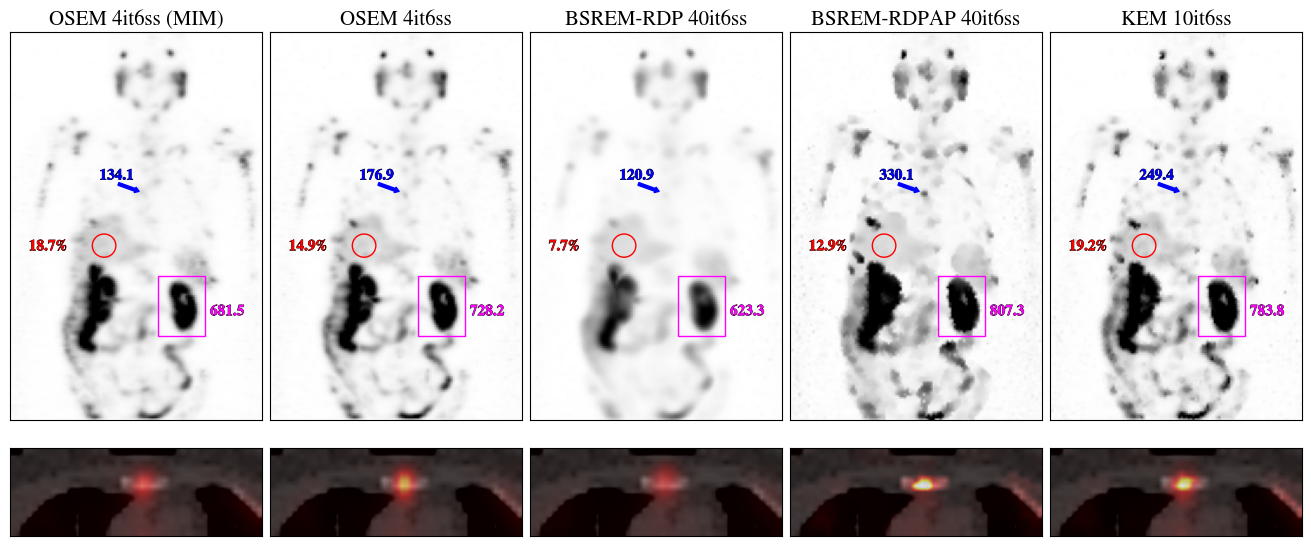

In [ ]:
idx_d = 75
vmax = 1000
fig = plt.figure(constrained_layout=True, figsize=(13,5.5))
subfigs = fig.subfigures(nrows=2, ncols=1, height_ratios=(1,0.3))

axes = subfigs[0].subplots(nrows=1, ncols=5)
ax = axes[0]
plot_object(dicomMIMOSEM[10:-10,:,20:-20], ax, idx=idx_d, vmax_set = vmax)
add_kidney_box_coronal(ax, MIM_OSEM_kidneyval)
add_liver_circle_coronal(ax, MIM_OSEM_livernoise)
add_tumour_box_coronal(ax, MIM_OSEM_lesionval)
ax.set_title('OSEM 4it6ss (MIM)', fontsize=15)

ax = axes[1]
plot_object(dicomOSEM[10:-10,:,20:-20], ax, idx=idx_d, vmax_set = vmax)
add_kidney_box_coronal(ax, OSEM_kidneyval)
add_liver_circle_coronal(ax, OSEM_livernoise)
add_tumour_box_coronal(ax, OSEM_lesionval)
ax.set_title('OSEM 4it6ss', fontsize=15)

ax = axes[2]
plot_object(dicomBSREM2[10:-10,:,20:-20], ax, idx=idx_d, vmax_set = vmax)
add_kidney_box_coronal(ax, BSREM2_kidneyval)
add_liver_circle_coronal(ax, BSREM2_livernoise)
add_tumour_box_coronal(ax, BSREM2_lesionval)
ax.set_title('BSREM-RDP 40it6ss', fontsize=15)

ax = axes[3]
plot_object(dicomBSREM3[10:-10,:,20:-20], ax, idx=idx_d, vmax_set = vmax)
add_kidney_box_coronal(ax, BSREM3_kidneyval)
add_liver_circle_coronal(ax, BSREM3_livernoise)
add_tumour_box_coronal(ax, BSREM3_lesionval)
ax.set_title('BSREM-RDPAP 40it6ss', fontsize=15)

ax = axes[4]
plot_object(dicomKEM[10:-10,:,20:-20], ax, idx=idx_d, vmax_set = vmax)
add_kidney_box_coronal(ax, KEM_kidneyval)
add_liver_circle_coronal(ax, KEM_livernoise)
add_tumour_box_coronal(ax, KEM_lesionval)
ax.set_title('KEM 10it6ss', fontsize=15)


vmax = 1000
axes = subfigs[1].subplots(nrows=1, ncols=5)
plot_axial_slice(dicomMIMOSEM, axes[0], vmax_set = vmax)
plot_axial_slice(dicomOSEM, axes[1], vmax_set = vmax)
plot_axial_slice(dicomBSREM2, axes[2], vmax_set = vmax)
plot_axial_slice(dicomBSREM3, axes[3], vmax_set = vmax)
plot_axial_slice(dicomKEM, axes[4], vmax_set = vmax)

plt.savefig('./figures/figure2.jpg', dpi=400)